## Setting

On présente une implémentation en tensorflow du modèle FNO (Fourier Neural Operator) venant de [cet article](https://openreview.net/pdf?id=c8P9NQVtmnO)

On y a apporté quelques modifications (d'où le nom FNO1D_plus)

Le très grands avantage d'un FNO est qui est qu'on peut l'entrainée avec des données calculée sur des grilles de résolutions variée et l'utiliser sur des grilles de résolution différente. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%reset -f

Mounted at /content/drive


In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
%cd /content/drive/Othercomputers/Mon MacBook Pro/google_saved/PYTHON/small_libs
%ls

/content/drive/Othercomputers/Mon MacBook Pro/google_saved/PYTHON/small_libs
consecutive_windows/      grid_up/    poubel/
derivator/                paddings/   preference_sampling/
fourier_neural_operator/  popup_lib/


In [ ]:
import fourier_neural_operator.FNO_1d_plus as fno
#import fourier_neural_operator.test_env as te
import grid_up.grid_up as gr

In [ ]:
pp=print
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Définition du modèle

Voici la signature du modèle

        FNO1d_plus( 
            modes:int, 
            width:int,
            out_channels:int,
            nb_layer=4,
            first_channel_unchanged=False,
            freq_mix_size=0,
            pad_prop=0.1,
            pad_kind="zero_padding",
            verbose=False)

* mode: nombre de coefficients de fourier gardés
* width: dimension de travail des layers
* out_channels: dimension de sortie
* nb_layer=4: le nombre de layers
* first_channel_unchanged=True Si l'on veut garder les fréquences inchangée dans le premier channel, à l'initialisation des poids (sorte de res-net fréquentiel)
* pad_prop: le padding des entrée est de taille pad_prop*len(signal) de chaque côtés
* pad_kind: type de padding (cf. ci-dessous)
* freq_mix_size: des convolutions de tailles freq_mix_size sont appliquées au fréquences


Les paddings sont à choisir dans la liste suivante:

In [ ]:
import paddings.paddings as pad

In [ ]:
pad.kind_dict.keys()

dict_keys(['zero_padding', 'dirichlet_padding', 'neumann_padding', 'smooth_padding', 'periodic_padding', 'smooth_periodizing_padding', 'linear_periodizing_padding'])

Ce qui correspond aux prolongements suivants:

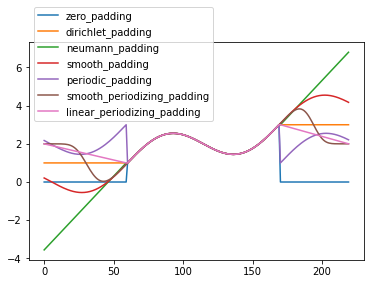

In [ ]:
pad.test_pad_1d()

In [ ]:
model = fno.FNO1d_plus(mode=20, width=15,out_channels=1,first_channel_unchanged=False,pad_prop=0.1,pad_kind="zero_padding",freq_mix_size=0,verbose=True)

modèle FNO1d crée avec comme hyperparamètre: modes:20, width:15,level:4, pad_prop:0.1 


## Un FNO peut apprendre à dériver

On demande au modèle de faire le lien entre une fonction et sa dérivée:

Input:

        x-> tf.sin(nu * 2 * np.pi * x ** 2)

Output:

        x-> nu * tf.cos(nu * 2 * np.pi * x ** 2) * 2 * x


pour différents `nu`



In [ ]:
data_creator_train=te.DataCreator1D(nx=80,batch_size=64)

In [ ]:
def train(model):
    optimizer=tf.keras.optimizers.Adam()
    losses=[]
    try:
        for i in range(1000):
            X,Y=data_creator_train.call()

            with tf.GradientTape() as tape:
                Y_pred=model.call(X)
                loss=data_creator_train.loss(Y,Y_pred)

            grad=tape.gradient(loss,model.trainable_variables)
            optimizer.apply_gradients(zip(grad,model.trainable_variables))
            losses.append(loss.numpy())

            if i%50==0:
                print(f"MSE train error at step:{i}: {loss.numpy()}",)
    except KeyboardInterrupt:
        pass

    fig,ax=plt.subplots()
    ax.plot(losses)
    ax.set_title("train loss")
    ax.set_yscale("log")

MSE train error at step:0: 0.0013413664419203997
MSE train error at step:50: 0.0023177284747362137
MSE train error at step:100: 0.001938655972480774
MSE train error at step:150: 0.0019062977517023683
MSE train error at step:200: 0.0011704076314345002
MSE train error at step:250: 0.001050727441906929
MSE train error at step:300: 0.0013832205440849066
MSE train error at step:350: 0.0006704826955683529
MSE train error at step:400: 0.0007039261981844902
MSE train error at step:450: 0.0007021196652203798
MSE train error at step:500: 0.0006728146690875292
MSE train error at step:550: 0.0006804423173889518
MSE train error at step:600: 0.0006230034050531685
MSE train error at step:650: 0.0011687648948282003
MSE train error at step:700: 0.0007959884824231267
MSE train error at step:750: 0.0005014838534407318
MSE train error at step:800: 0.00033927796175703406
MSE train error at step:850: 0.00033115115365944803
MSE train error at step:900: 0.00028554629534482956
MSE train error at step:950: 0.00

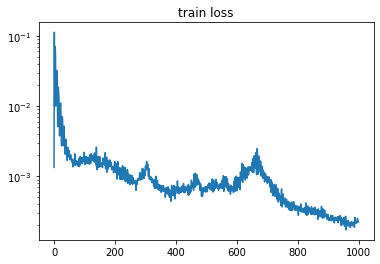

In [ ]:
losses=train(model)

## Test dans la résolution de l'entrainement

In [ ]:
def display_results(data_creator:te.DataCreator1D,model):

    nb=8# <= data_creator.batch_size
    fig,axs=plt.subplots(nb,4,sharey="row",sharex="all",figsize=(20,2*nb))
    A,U=data_creator.call()
    U_hat = model.call(A)
    print(f"MSE error with resolution nx:{data_creator.nx}:",data_creator.loss(U,U_hat))
    for i in range(nb):
        error = U[i, :, 0] - U_hat[i, :, 0]
        axs[i,0].plot(A[i,:,0])
        axs[i,1].plot(U[i,:,0])
        axs[i,2].plot(U_hat[i,:,0])
        axs[i,3].plot(error)

    axs[0,0].set_title("input")
    axs[0,1].set_title("output")
    axs[0,2].set_title("prediction")
    axs[0,3].set_title("error")

    plt.show()


MSE error with resolution nx:80: tf.Tensor(0.00023996914, shape=(), dtype=float32)


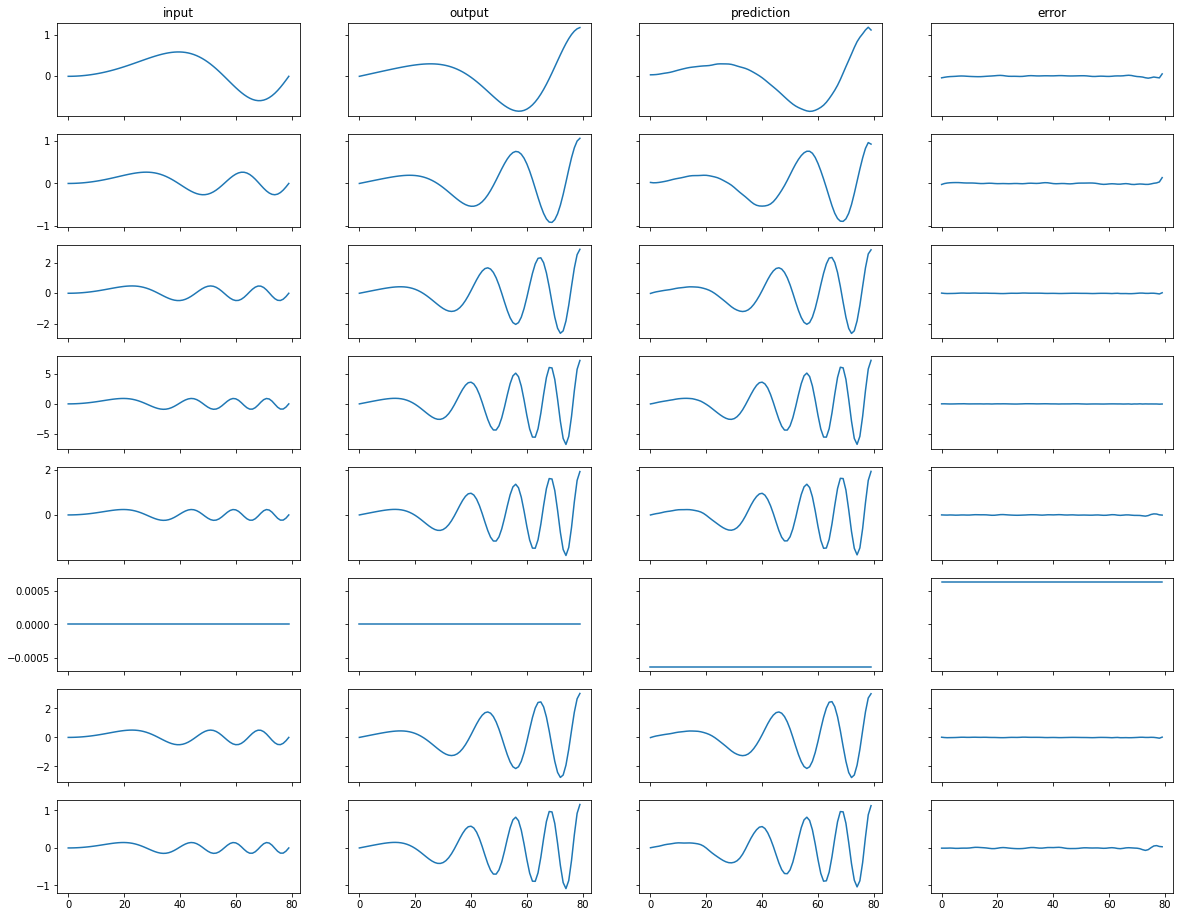

In [ ]:
display_results(data_creator_train,model)

## Test avec résolution supèrieure

traçage de la méthode call de FNO1d_plus, pad=15
MSE error with resolution nx:150: tf.Tensor(0.00090276566, shape=(), dtype=float32)


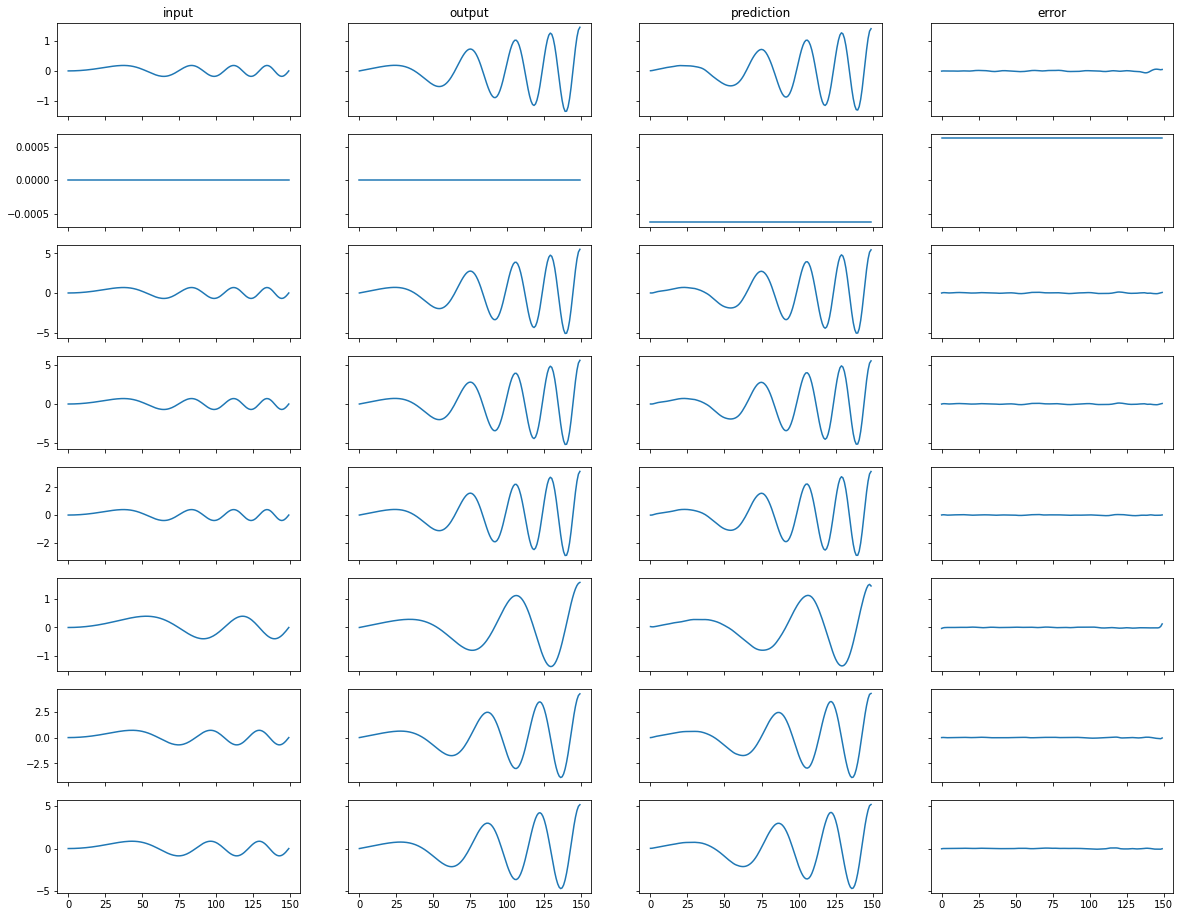

In [ ]:
data_creator_test=te.DataCreator1D(150,64)
display_results(data_creator_test,model)

## Test avec résolution inférieure

traçage de la méthode call de FNO1d_plus, pad=5
MSE error with resolution nx:50: tf.Tensor(0.0010809257, shape=(), dtype=float32)


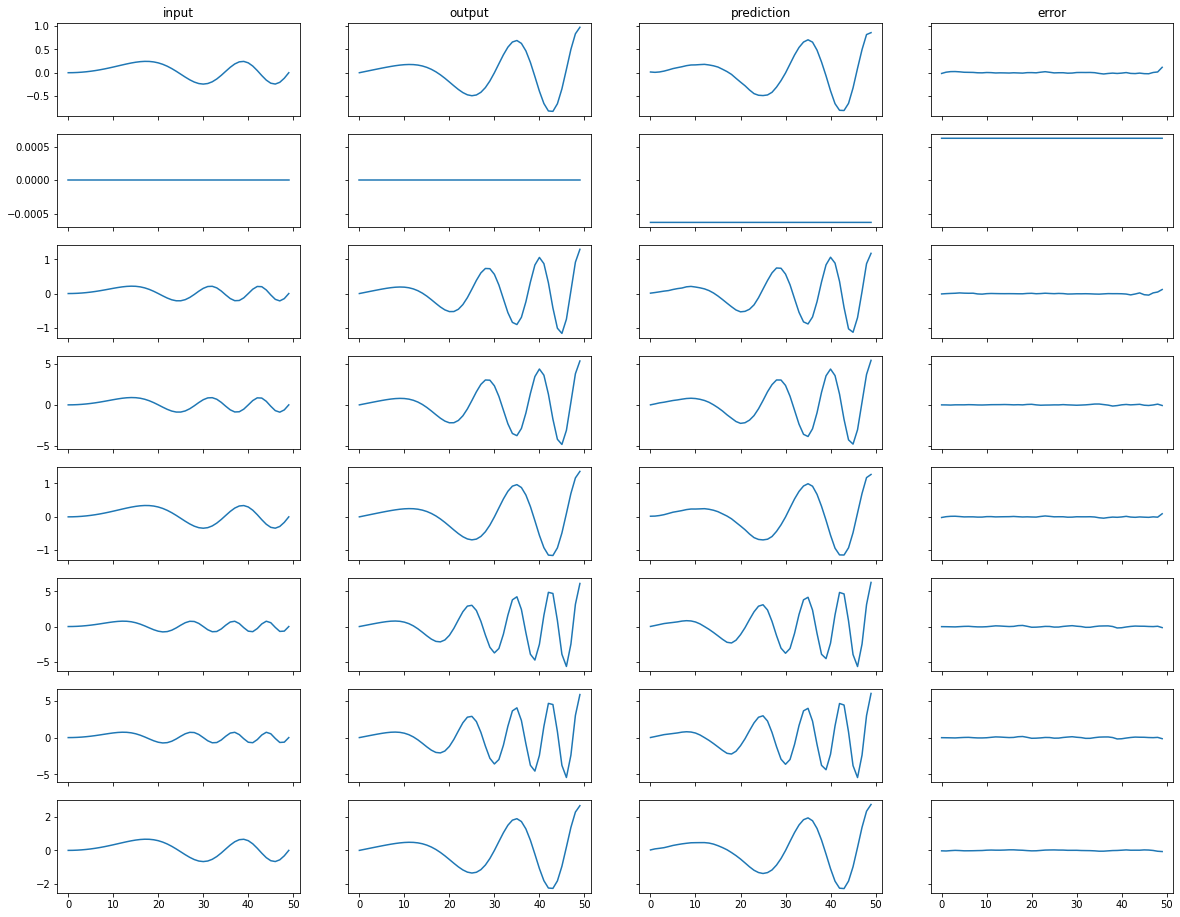

In [ ]:
data_creator_test=te.DataCreator1D(50,64)
display_results(data_creator_test,model)

## test d'hyper paramètre

Nous allons faire varier un à un les paramètres du FNO en partant de la configuration suivante:

In [ ]:
class DataCreator1D(gr.GridUp_dataMaker):


    def nus_intensities(self,batch_size):
        nus=tf.floor(tf.random.uniform(minval=0.5, maxval=5, shape=[batch_size, 1, 1]))
        intensities=tf.random.uniform(minval=0.1,maxval=1.,shape=[batch_size,1,1])
        return nus,intensities

    def make_XY(self, batch_size) -> tuple:
        nus, intensities = self.nus_intensities(batch_size)
        X = self.X_fun(self.grid, nus) * intensities
        Y = self.Y_fun(self.grid, nus) * intensities
        return X, Y


    def plot_prediction(self, ax, model: tf.keras.Model) -> None:
        tf.random.set_seed(123)
        X,Y=self.generate_XY(1)
        Y_pred=model(X)
        ax.plot(X[0,:],label="X")
        ax.plot(Y[0,:],label="Y")
        ax.plot(Y_pred[0,:],label="Y_pred")

    def score(self, model) -> dict:
        X,Y=self.make_XY(1024)
        Y_pred=model(X)
        return {"mse":tf.reduce_mean((Y - Y_pred) ** 2)}


    def __init__(self,nx):
        self.nx=nx

        self.X_fun  = lambda x,nu: tf.sin(nu * 2 * np.pi * x ** 2)
        self.Y_fun = lambda x,nu: nu * tf.cos(nu * 2 * np.pi * x ** 2) * 2 * x
        #
        # self.A_fun = lambda x, nu: -tf.sin(nu * x)+0.5*tf.sin(2*nu * x)
        # self.U_fun = lambda x, nu: tf.cos(nu * x) ** 5 +0.3*tf.cos(2*nu * x)

        self.grid = tf.linspace(0., 1, self.nx)[tf.newaxis, :, tf.newaxis]

In [ ]:

class SimpleAgent(gr.GridUp_agent):

    def __init__(self,modes, width,nb_layer,first_channel_unchanged,freq_mix_size,pad_prop,pad_kind,verbose=False):
        self.model = fno.FNO1d_plus(modes, width,1,nb_layer,first_channel_unchanged,freq_mix_size,pad_prop,pad_kind)
        self.optimizer = tf.keras.optimizers.Adam()
        self.batch_size = 512

    def get_model(self):
        return self.model

    @tf.function
    def train_step(self, data_maker: gr.GridUp_dataMaker):
        X,Y=data_maker.make_XY(self.batch_size)
        with tf.GradientTape() as tape:
            Y_pred=self.model.call(X)
            loss=tf.reduce_mean(tf.square(Y-Y_pred))
        tv=self.model.trainable_variables
        grad=tape.gradient(loss,tv)
        self.optimizer.apply_gradients(zip(grad,tv))
        return loss


In [ ]:
def make_testor():
    resolutions_train=[100,150]
    resolutions_test=[50,75,100,125,150,175,200]

    creator_train={nx:DataCreator1D(nx) for nx in resolutions_train}
    creator_test= {nx:DataCreator1D(nx) for nx in resolutions_test}

    fixed_params = {
        "first_channel_unchanged": False,
        "pad_prop": 0.1,
        "freq_mix_size": 5,
        "pad_kind": "smooth_padding",
        "modes" : 20,
        "width" : 15,
        "nb_layer":4,
    }

    pad_kinds=[
        'no_padding',
        #'zero_padding',
        'dirichlet_padding', 
        'neumann_padding', 
        'smooth_padding', 
        #'periodic_padding', 
        'smooth_periodizing_padding', 
        'linear_periodizing_padding']
    
    varying_params= {
        "first_channel_unchanged": [True,False],
        "pad_prop": [0,0.02,0.05,0.1,0.2],
        "freq_mix_size": [0,5,9],
        "pad_kind": pad_kinds,
        "modes" : [5,10,15,20],
        "width" : [5,10,15,20,30],
        "nb_layer":[2,3,4,5]
    }

    testor=gr.GridUp(
        SimpleAgent,
        creator_train,
        creator_test,
        fixed_params=fixed_params,
        varying_params=varying_params,
        minutes=0.1,
        verbose=False
    )
    return testor

testor=make_testor()

In [ ]:
testor.watch_param("first_channel_unchanged");

Look for agent.first_channel_unchanged=[True, False]. Train with data-cases:[100, 150], Test with data-cases:[50, 75, 100, 125, 150, 175, 200]
Other parameters are: [('pad_prop', 0.1), ('freq_mix_size', 5), ('pad_kind', 'smooth_padding'), ('modes', 20), ('width', 15), ('nb_layer', 4)]


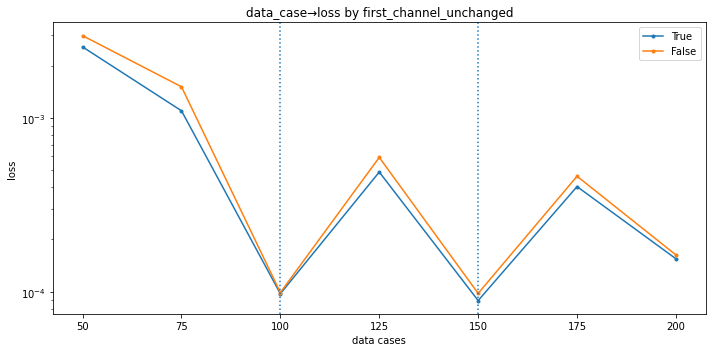

In [ ]:
testor.plot_last_result();

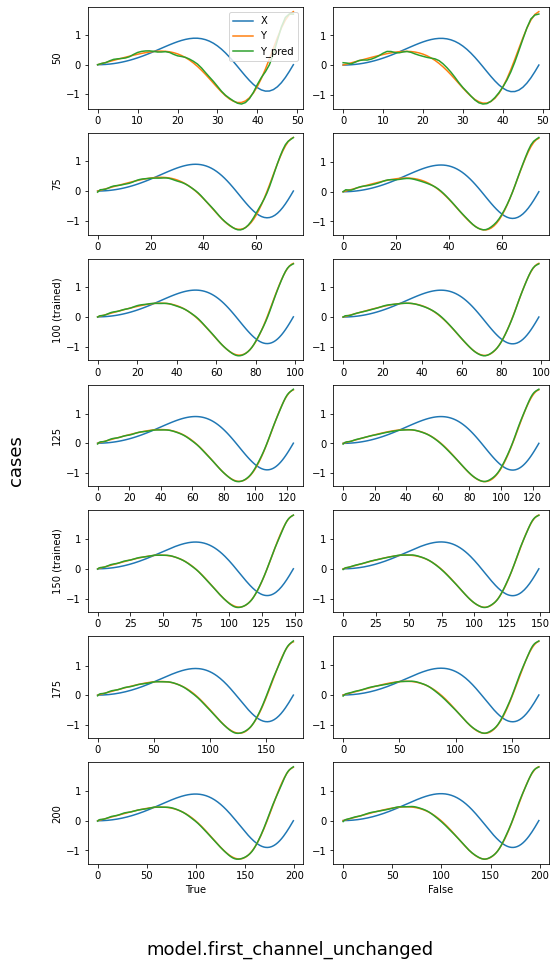

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("pad_prop");

Look for model.pad_prop=[0, 0.02, 0.05, 0.1, 0.2]. Train with data-cases:[100, 150], Test with data-cases:[50, 75, 100, 125, 150, 175, 200]
Other parameters are: [('first_channel_unchanged', False), ('freq_mix_size', 5), ('pad_kind', 'smooth_padding'), ('modes', 20), ('width', 15), ('nb_layer', 4), ('out_channels', 1)]


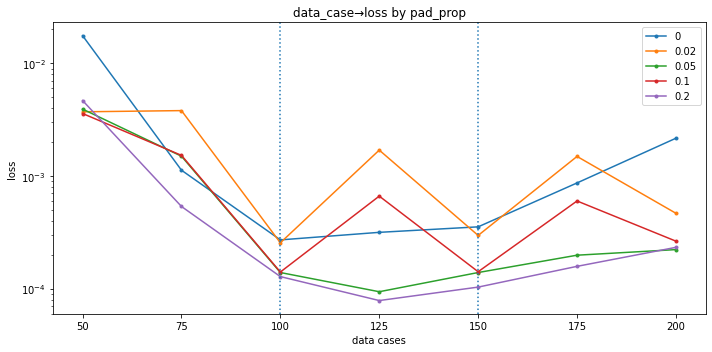

In [ ]:
testor.plot_last_result();

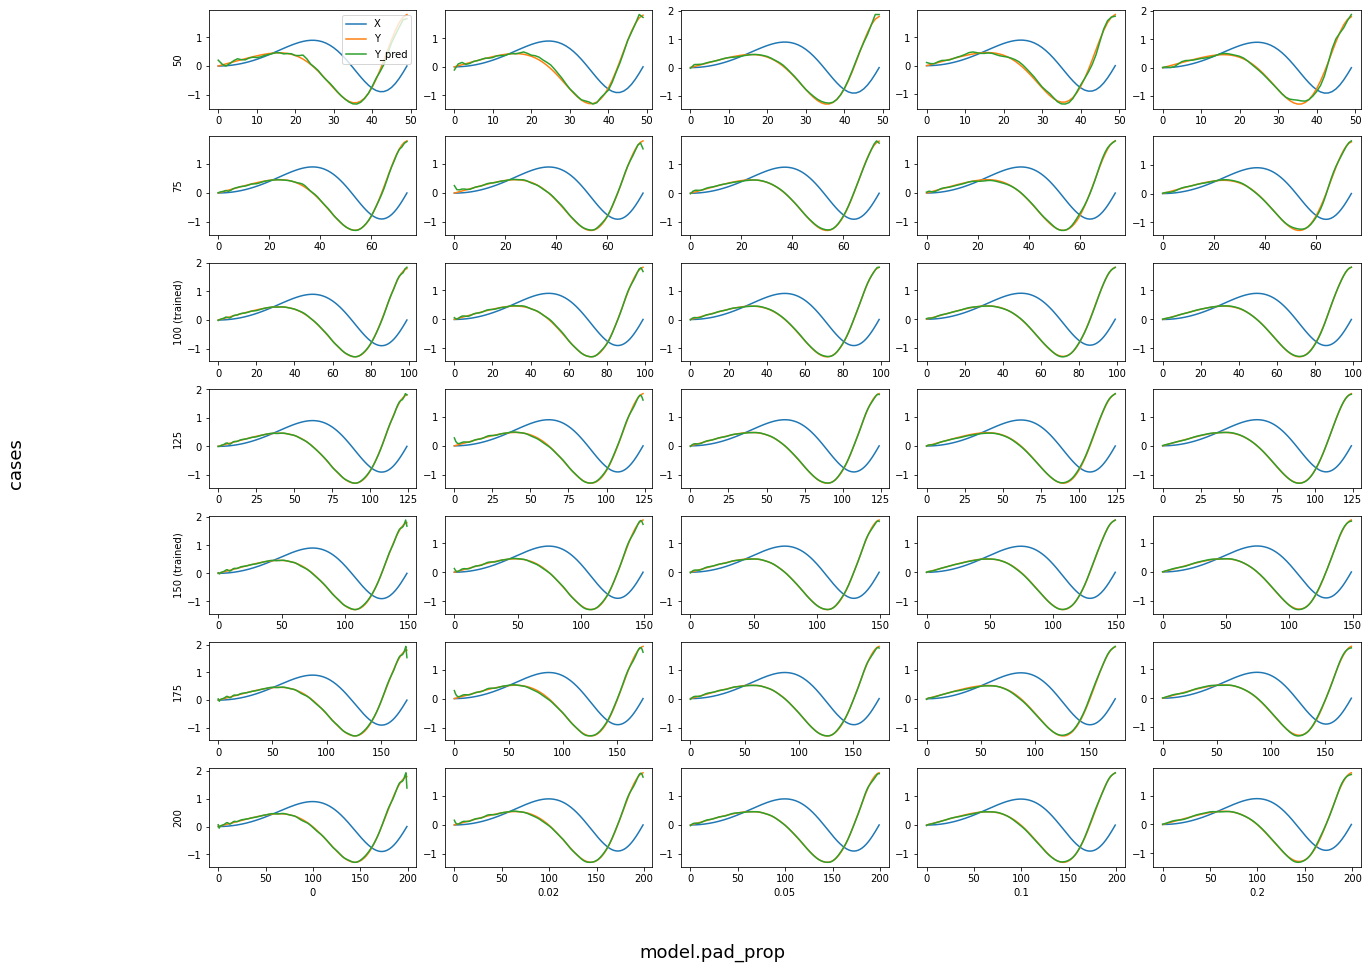

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("freq_mix_size");

Look for model.freq_mix_size=[0, 5, 9]. Train with data-cases:[100, 150], Test with data-cases:[50, 75, 100, 125, 150, 175, 200]
Other parameters are: [('first_channel_unchanged', False), ('pad_prop', 0.1), ('pad_kind', 'smooth_padding'), ('modes', 20), ('width', 15), ('nb_layer', 4), ('out_channels', 1)]


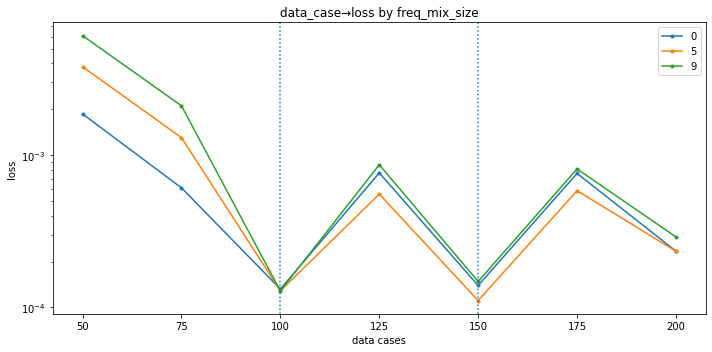

In [ ]:
testor.plot_last_result();

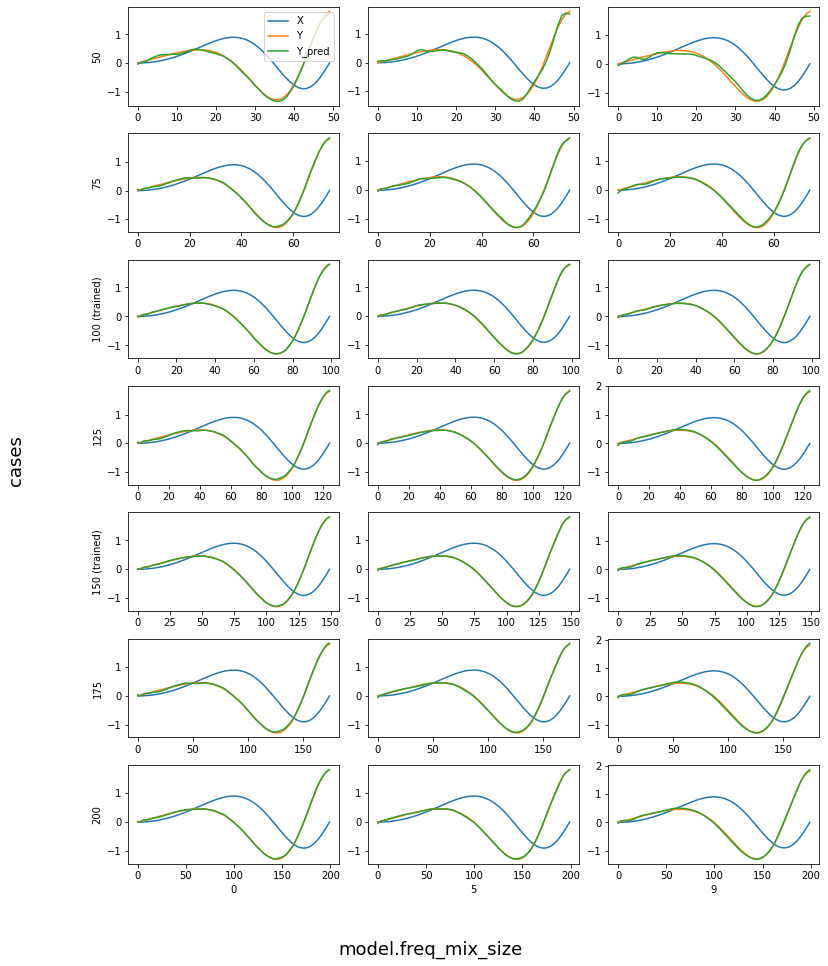

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("pad_kind");

Look for model.pad_kind=['no_padding', 'dirichlet_padding', 'neumann_padding', 'smooth_padding', 'smooth_periodizing_padding', 'linear_periodizing_padding']. Train with data-cases:[100, 150], Test with data-cases:[50, 75, 100, 125, 150, 175, 200]
Other parameters are: [('first_channel_unchanged', False), ('pad_prop', 0.1), ('freq_mix_size', 5), ('modes', 20), ('width', 15), ('nb_layer', 4), ('out_channels', 1)]


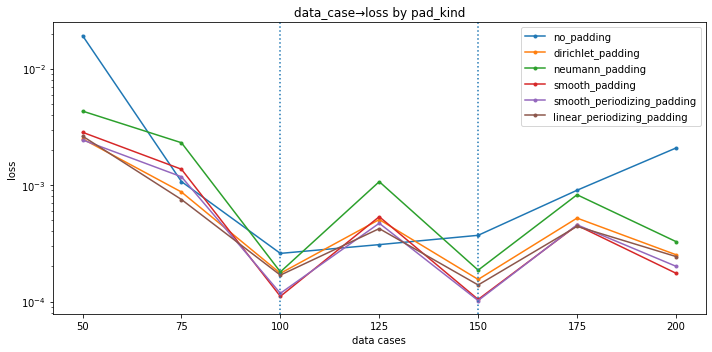

In [ ]:
testor.plot_last_result();

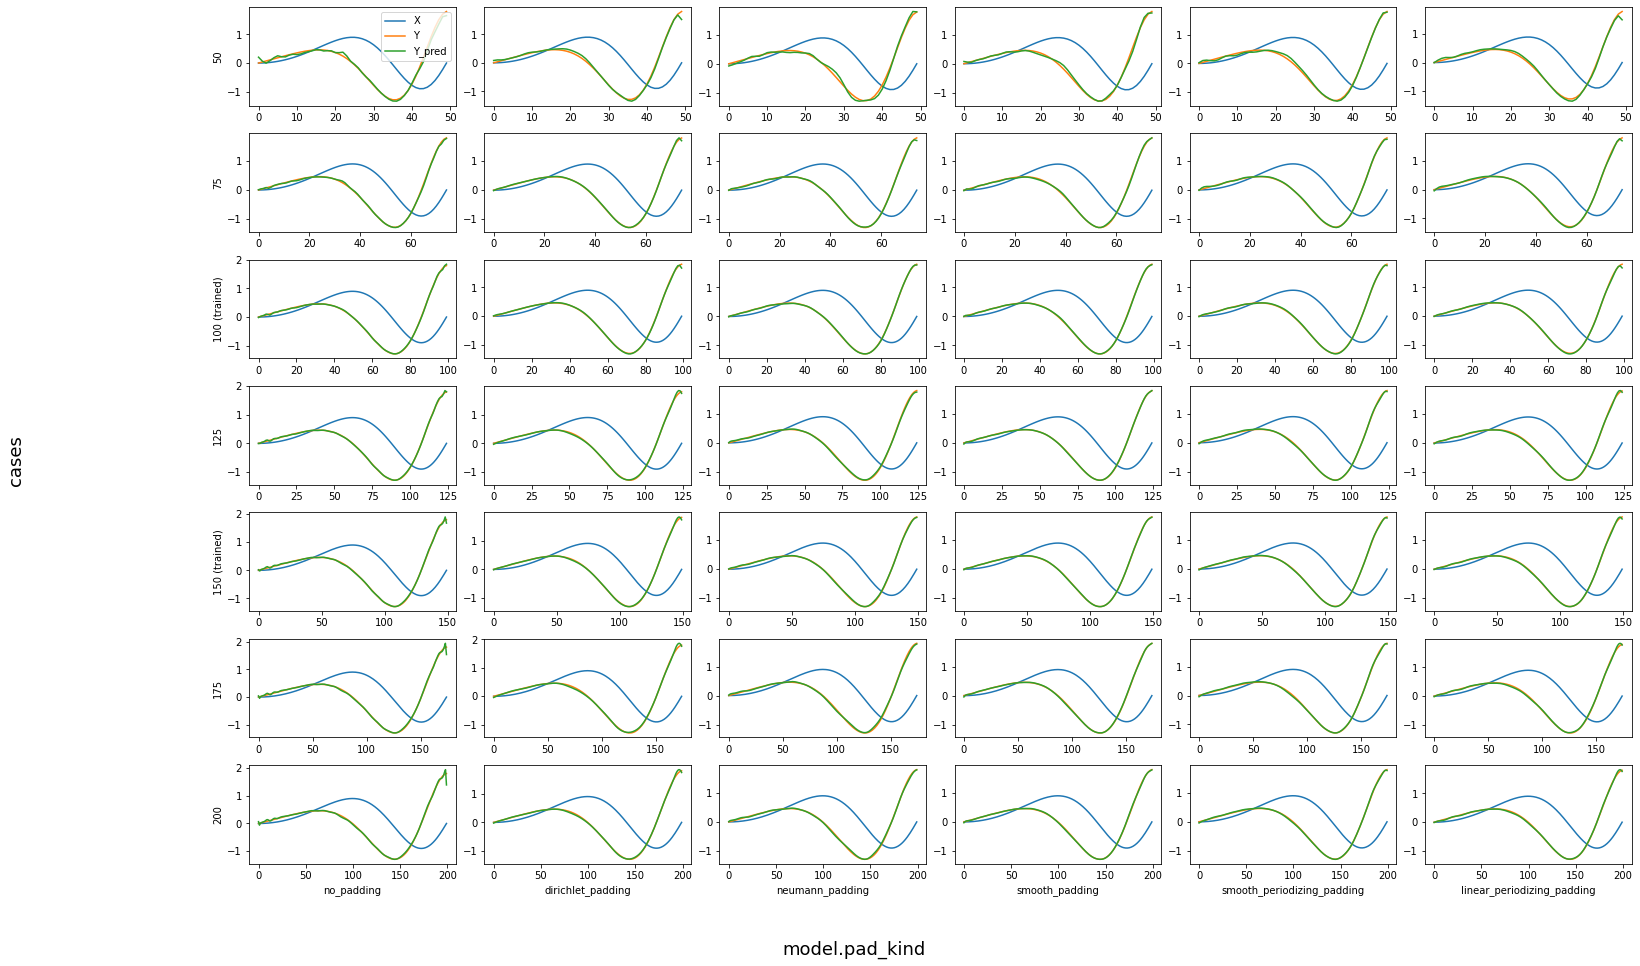

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("modes");

Look for model.modes=[5, 10, 15, 20]. Train with data-cases:[100, 150], Test with data-cases:[50, 75, 100, 125, 150, 175, 200]
Other parameters are: [('first_channel_unchanged', False), ('pad_prop', 0.1), ('freq_mix_size', 5), ('pad_kind', 'smooth_padding'), ('width', 15), ('nb_layer', 4), ('out_channels', 1)]


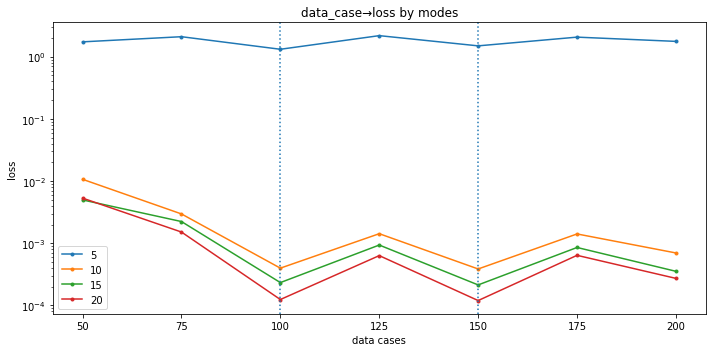

In [ ]:
testor.plot_last_result();

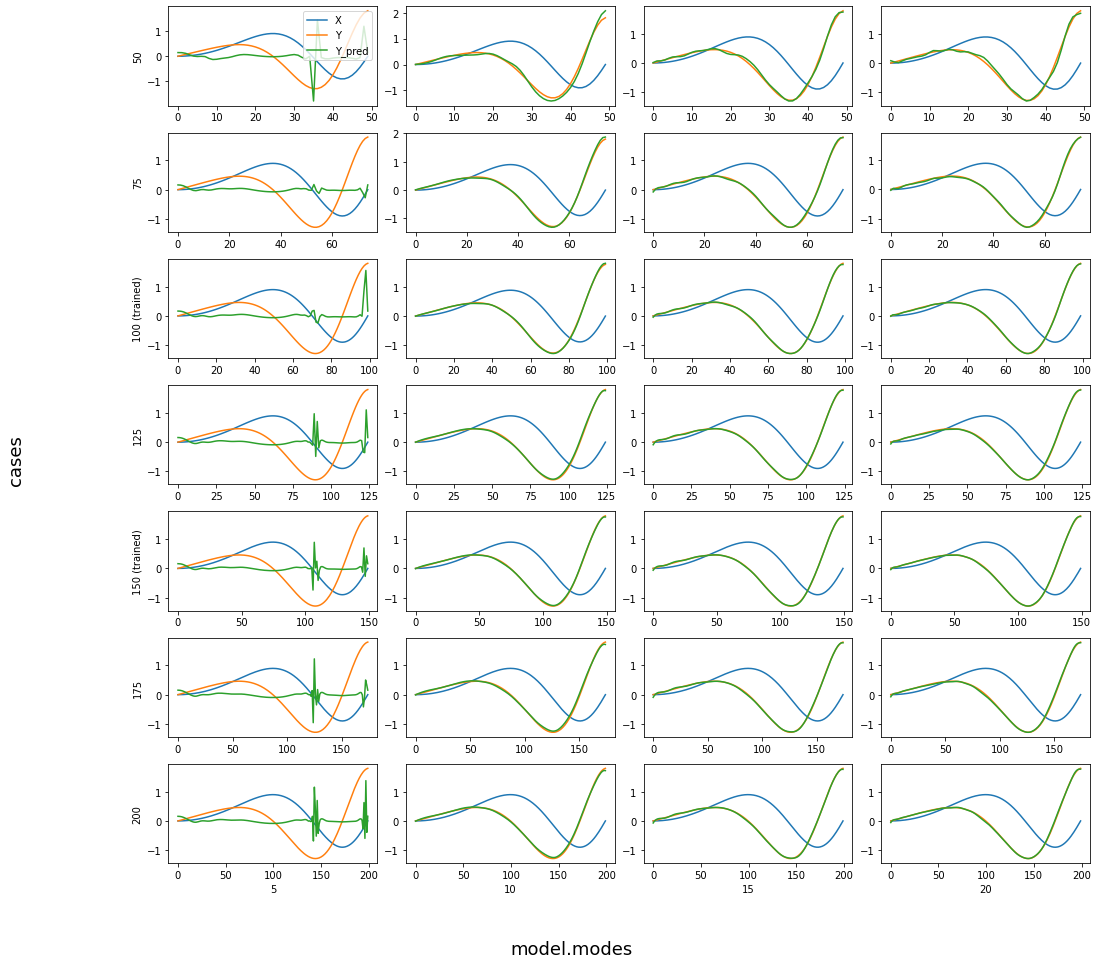

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("width");

Look for model.width=[5, 10, 15, 20, 30]. Train with data-cases:[100, 150], Test with data-cases:[50, 75, 100, 125, 150, 175, 200]
Other parameters are: [('first_channel_unchanged', False), ('pad_prop', 0.1), ('freq_mix_size', 5), ('pad_kind', 'smooth_padding'), ('modes', 20), ('nb_layer', 4), ('out_channels', 1)]


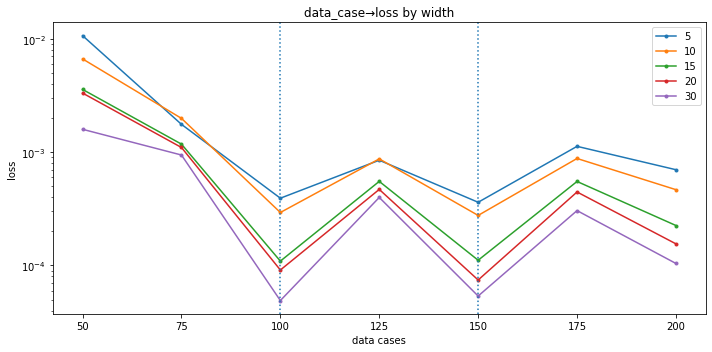

In [ ]:
testor.plot_last_result();

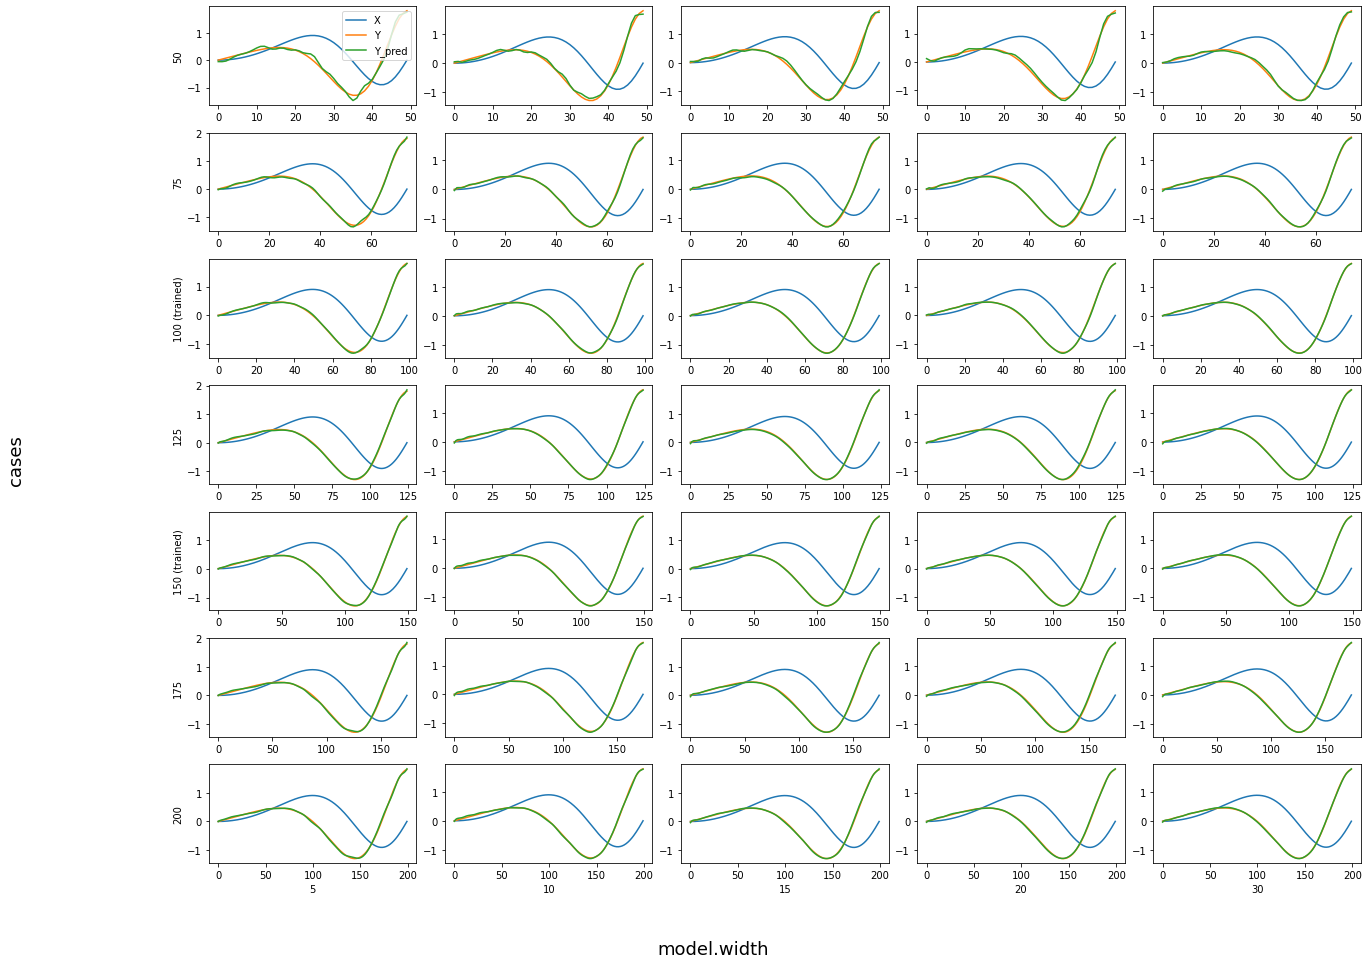

In [ ]:
testor.plot_prediction();

In [ ]:
testor.watch_param("nb_layer");

Look for model.nb_layer=[2, 3, 4, 5]. Train with data-cases:[100, 150], Test with data-cases:[50, 75, 100, 125, 150, 175, 200]
Other parameters are: [('first_channel_unchanged', False), ('pad_prop', 0.1), ('freq_mix_size', 5), ('pad_kind', 'smooth_padding'), ('modes', 20), ('width', 15), ('out_channels', 1)]


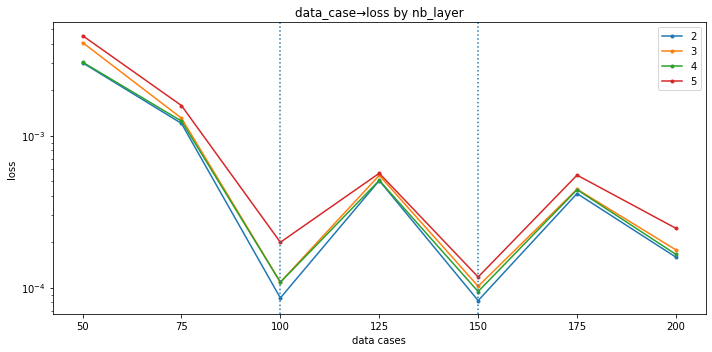

In [ ]:
testor.plot_last_result();

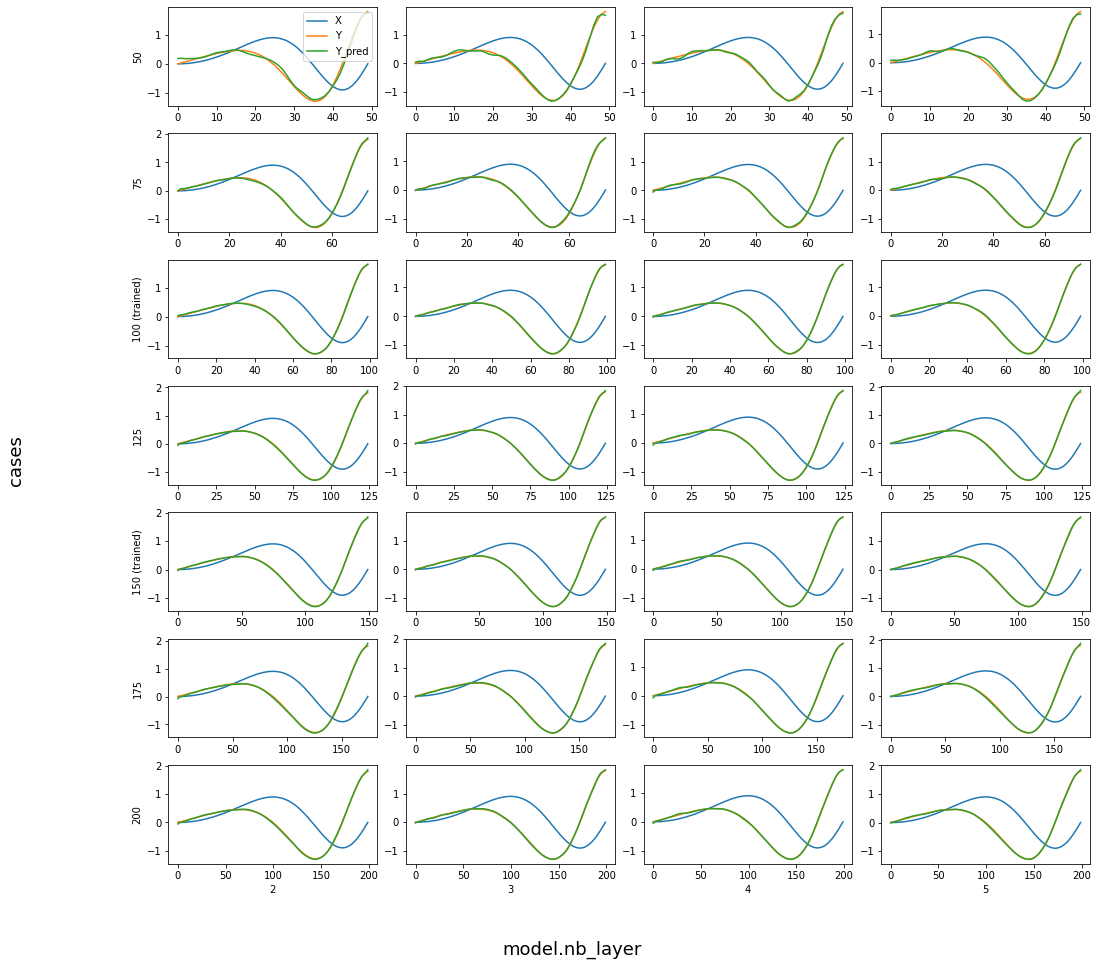

In [ ]:
testor.plot_prediction();

## En interne

Le FNO est constitué de `nb_layer` layers effectuant des convolutions par fft. Ils sont enchainé avec des connections résiduelles.

Voici la signature d'un layer. Remarquons qu'un layer peut servir de prétraitement à un autre réseau (ex: Unet). Car il permet d'interpoler (possibilité d'imposer un longueur de signal en sortie avec l'argument `N_out_imposed`). 

        SpectralConv1d_plus(
            in_channels:int, 
            out_channels:int, 
            modes:int,
            first_channel_unchanged:bool,
            N_out_imposed=None,
            freq_mix_size=0):


* in_channels:int dimension d'entrée
* out_channels:int dimension de sortie
* modes:int nombre de fréquences filtrées
* first_channel_unchanged:bool: voir au dessus
* N_out_imposed: si l'on veut que la longueur du signal en sortie soit différente de celle en entrée.
* freq_mix_size=0: voir au dessus
